In [16]:
import os
# Use a local kadi events.db3 so you don't break the kadi cron job if this takes a while
os.environ['KADI'] = '/proj/sot/ska/jeanproj/git/proseco'
import numpy as np
from Quaternion import Quat
from Ska.quatutil import radec2yagzag
import agasc
from astropy.table import Table
from mica.starcheck import get_starcat, get_dither, get_att, get_starcheck_catalog

In [17]:
import kadi
import kadi.paths
from kadi import events

In [18]:
kadi.paths.DATA_DIR()

'/proj/sot/ska/jeanproj/git/proseco'

In [19]:
from annie import Spacecraft
import annie.validation as val
import astropy.units as u
import annie
annie.test(get_version=True)

'0.6-r144-eaa0260'

In [20]:
import proseco
from proseco.guide import get_guide_catalog

In [6]:
pver = proseco.test(get_version=True)
proseco.test(get_version=True)

'4.0-r380-504ce92'

In [7]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)

In [8]:
def annie_eval(att, dither, starcat, date, t_ccd, dur=20):

    # Run an annie sim for the given params
    sc = Spacecraft()
    sc.track_stars_setup(att_cmd=att, dither=dither, starcat=starcat,
                         ccd_bgd_data=date,  t_ccd=t_ccd,
                         stop=dur * u.second)
    sc.run()
    sc.telem.clip()

    # Get DR
    atts_true = sc.telem.pcad_att['att_true']
    atts_est = sc.telem.pcad_att['att_est']
    dr = []
    for att_true, att_est in zip(atts_true, atts_est):
        dq = att_true.dq(att_est)
        dr.append(dq.roll0 * 3600)

    # Get KALM issues
    no_kalm = consecutive((np.array(sc.telem.n_Kalman_stars) == 0).astype(int))
    no_kalm_dur= np.array([len(interv) for interv in no_kalm])

    # Get star residuals
    res = []
    for s in starcat:
        slot = s['slot']
        sim = val.SimAca(sc.telem, slot=slot)
        ys = sim.delta_ys[sim.Kalman_oks]
        zs = sim.delta_zs[sim.Kalman_oks]
        rms_y = np.sqrt(np.mean((ys - np.median(ys)) ** 2))
        rms_z = np.sqrt(np.mean((zs - np.median(zs)) ** 2))
        res.append({'slot': slot,
                    'y': rms_y,
                    'z': rms_z})
    return {'no_kalm_dur': np.max(no_kalm_dur),
            'dr95th': np.percentile(dr, 95),
            'res': res, 'sim': sc, 'drs': dr}

In [21]:
cfile = f'compare_{pver}.dat'
if os.path.exists(cfile):
    dwells = []
else:
    compare = []
    dwells = events.dwells.filter(start="2015:001")

for d in dwells:
    try:
        obsid = d.get_obsid()
    except:
        continue
    if obsid == 0 or obsid > 38000:
        continue

    obs = get_starcheck_catalog(obsid)
    if obs is None or 'cat' not in obs or len(obs['cat']) == 0:
        continue
    if 'pred_temp' not in obs:
        continue
    
    sc_cat = get_starcat(obsid)
    dither = get_dither(obsid)
    att = get_att(obsid)
    date = obs['obs']['mp_starcat_time']
    t_ccd = obs['pred_temp']
    
    # Speed everything up a bit (hopefully this won't break everything much)
    dither['pitch_period'] *= .5
    dither['yaw_period'] *= .5

    scgui = sc_cat[(sc_cat['type'] == 'GUI') | (sc_cat['type'] == 'BOT')]
    if len(scgui) == 0:
        continue
    n = 5 if obsid < 38000 else 8
    if (len(scgui) > 5) or ('MON' in sc_cat['type']):
        n = len(scgui)

    guis = get_guide_catalog(obsid, n_guide=n)
    match = len(set(guis['id']).intersection(set(scgui['id'])))
    if match == len(guis['id']):
        continue
        
    oldcat = annie_eval(att=att, dither=dither, starcat=scgui,
                        date=date,
                        t_ccd=t_ccd,
                        dur=1000)

    q = Quat(att)
    cat = []
    for aid in guis['id']:
        star = agasc.get_star(aid, date=date)
        yag, zag = radec2yagzag(star['RA_PMCORR'], star['DEC_PMCORR'], q)
        row = {'yang': yag * 3600,
               'zang': zag * 3600,
               'sz':'6x6',
               'maxmag': star['MAG_ACA'] + 1.5,
               'type': 'GUI',
               'halfw': 25}
        cat.append(row)
    cat = Table(cat)
    cat['slot'] = np.arange(0, len(cat))

    newcat = annie_eval(att=att, dither=dither, starcat=cat,
                        date=date,
                        t_ccd=t_ccd,
                        dur=1000)
    rec = {'obsid': obsid,
           'match': len(set(guis['id']).intersection(set(scgui['id']))),
           'p_n': len(guis),
           's_n': len(scgui),
           'old_nkd': oldcat['no_kalm_dur'],
           'new_nkd': newcat['no_kalm_dur'],
           'old_dr95th': oldcat['dr95th'],
           'new_dr95th': newcat['dr95th']}
    
    for slot in range(0, 5):
        try:
            rec[f'old_s{slot}_y'] = oldcat['res'][slot]['y']
            rec[f'old_s{slot}_z'] = oldcat['res'][slot]['z']
        except:
            rec[f'old_s{slot}_y'] = -1
            rec[f'old_s{slot}_z'] = -1
        try:
            rec[f'new_s{slot}_y'] = newcat['res'][slot]['y']
            rec[f'new_s{slot}_z'] = newcat['res'][slot]['z']
        except:
            rec[f'new_s{slot}_y'] = -1
            rec[f'new_s{slot}_z'] = -1
    compare.append(rec)

    if len(compare) > 1:
        Table(compare).write(cfile, format='ascii', overwrite=True)           

In [22]:
if os.path.exists(cfile):
    tc = Table.read(cfile, format='ascii')
else:
    tc = Table(compare)

In [23]:
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt

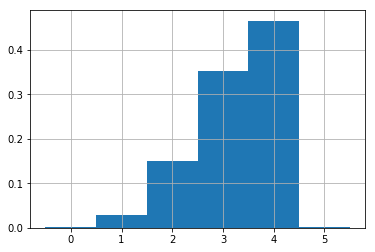

In [25]:
plt.hist(tc['match'], bins=range(0, 7), align='left', normed=True)
plt.grid()

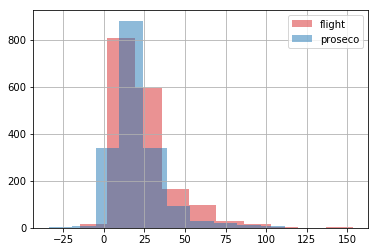

In [26]:
plt.figure()
plt.hist(tc['old_dr95th'], label='flight', alpha=.5, color='C3')
plt.hist(tc['new_dr95th'], label='proseco', alpha=.5, color='C0')
plt.grid()
plt.legend();

In [27]:
tc['obsid', 'match', 'old_dr95th', 'new_dr95th'][tc['new_dr95th'] > 80]

obsid,match,old_dr95th,new_dr95th
int64,int64,float64,float64
16147,3,45.066178293,111.34953554
17223,4,57.9622872677,84.6607369902
17632,4,68.6331891611,93.6209989933
17387,4,38.4380979754,88.9601936753
17389,4,36.0088021155,87.2274541696
17392,4,52.8346808084,86.3873310569
17865,4,34.4432931601,90.5754060813
18422,3,85.4386789647,107.824350437
18340,4,68.7327501448,90.2128793299
